In [731]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import cv2
from pathlib import Path
import sys

In [732]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [733]:
class ModelV1(nn.Module):
    def __init__(self):
        super(ModelV1, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=5
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=13456,
                out_features=20
            ),
            nn.Tanh(),
            nn.Linear(
                in_features=20,
                out_features=1
            )
        )
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x

In [734]:
class MRI(Dataset):
    def __init__(self, path, transform=None):
        self.images = []
        self.labels = []
        data_path = Path(path)
        image_path_list = list(data_path.glob("*/*.jpg"))
        for i in range(len(image_path_list)):

            if image_path_list[i].parent.stem == "no":
                self.labels.append(0)
            else:
                self.labels.append(1)
            img = cv2.imread(image_path_list[i])
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = torch.from_numpy(img).type(torch.float32) / 255
            
            if transform is not None:
                tImg = transform(img)
                tImg = tImg.permute(2, 1, 0)
                self.images.append(tImg)
                if image_path_list[i].parent.stem == "no":
                    self.labels.append(0)
                else:
                    self.labels.append(1)
                    
            img = img.permute(2, 1, 0)
            self.images.append(img)
        self.labels = torch.tensor(self.labels).type(torch.float32)
         
    def __getitem__(self, idx):

        sample = {'image': self.images[idx], 'label': self.labels[idx]}
        
        return sample
    
    def __len__(self):
        return len(self.images)
    
    def normalize(self):
        self.images = self.images / 255.0

    def image_show(self, index):
        plt.imshow(self.images[index].reshape(self.images[index].shape[2], self.images[index].shape[1], self.images[index].shape[0]))
        title = "Yes" if self.labels[index] else "No"
        plt.title(f"Tumor Situation: {title}")
        plt.axis(False)



In [735]:

train_transform = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, 5)),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomHorizontalFlip(0.5)
])

In [736]:
mri_train = MRI("data/brain_tumor_dataset/train", transform=train_transform)
mri_test = MRI("data/brain_tumor_dataset/test")
model = ModelV1().to(device)

In [737]:
train_dataloader = DataLoader(mri_train, batch_size=18, shuffle=True)
test_dataloader = DataLoader(mri_test, batch_size=18, shuffle=False)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)
accuracies = []

In [747]:
EPOCHS = 50
outputs = []
y_true = []
for i in range(1, EPOCHS):
    losses = []
    model.train()
    for _, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        img, label = data["image"].to(device), data["label"].to(device).unsqueeze(1)
        y_pred = model(img)
        loss_fn = nn.BCELoss()
        loss = torch.sum(loss_fn(y_pred, label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (i+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(i+1, np.mean(losses)))
    
    if i % 10 == 0:
        model.eval()
        with torch.no_grad():
            for _, data in enumerate(test_dataloader):
                image = data['image'].to(device)
                label = data['label'].to(device).unsqueeze(1)
                
                y_pred = model(image)
                predictions = (y_pred >= 0.5).float()

                outputs.append(predictions.cpu().numpy())
                y_true.append(label.cpu().detach().numpy())
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()
acc = accuracy_score(y_true, outputs)
print(acc)
accuracies.append(acc)          

Train Epoch: 10	Loss: 0.008662
Train Epoch: 20	Loss: 0.008358
Train Epoch: 30	Loss: 0.008044
Train Epoch: 40	Loss: 0.008281
Train Epoch: 50	Loss: 0.007617
0.8125


In [748]:
print(accuracies)

[0.7708333333333334, 0.796875, 0.8125, 0.8125]


[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

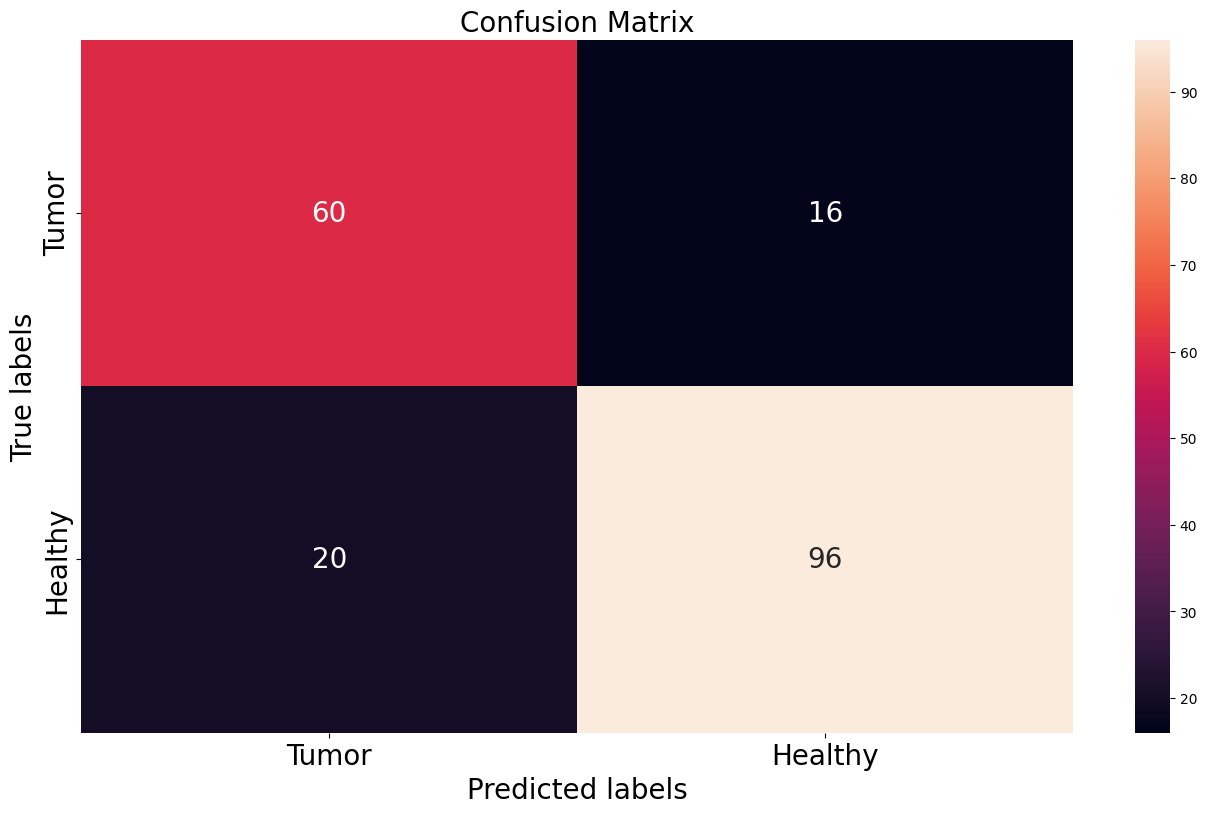

In [749]:
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, outputs)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [741]:

train_transform = transforms.Compose([
    transforms.RandomRotation(135),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 5))
])

In [742]:
custom_img = Path("data/no/no 99.jpg")
custom_img = cv2.imread(custom_img)
custom_img = cv2.resize(custom_img, (128, 128))
b, g, r = cv2.split(custom_img)
img = cv2.merge([r, g, b])
img = torch.from_numpy(img).type(torch.float32) / 255
img = img.permute(2, 1, 0).unsqueeze(0)

model.eval()
with torch.no_grad():
    custom_pred = model(img.to(device))
    pred = (custom_pred >= 0.5).float()
print(custom_pred)
print(pred)


tensor([[0.5045]], device='cuda:0')
tensor([[1.]], device='cuda:0')


Text(0.5, 1.0, 'Pred: 1.0')

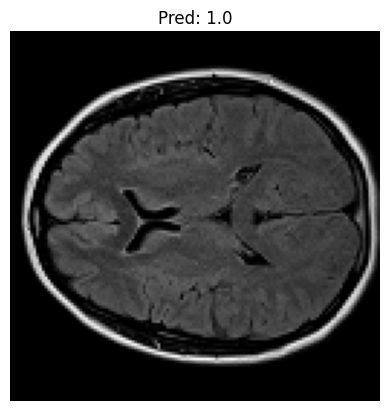

In [743]:
plt.imshow(img.squeeze().permute(1, 2, 0))
title = f"Pred: {pred[0][0]}"
plt.axis(False)
plt.title(title)

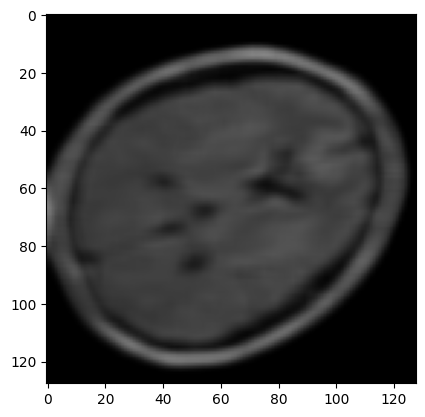

In [744]:
imgShow = img.squeeze()
imgShow = train_transform(imgShow)
plt.imshow(imgShow.permute(2, 1, 0).numpy())